# D5: Inference

In this notebook, we'll use statistical approaches to attempt to determine what countries the best soccer (football, for the rest of the world) players come from. Some argue that Brazil produces the best footballers, while others argue it's got to be France. (And other have different opinions still.) We'll investigate this question using FIFA data from 2020.

Run the following cell. These are all you need for the assignment. Do not import additional packages.

In [71]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 104)
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

## Part 1: Data & Wrangling

Fixing messy data makes up a large amount of the work of being a data scientist. 

The real world produces messy measurements and it is your job to find ways to standardize your data such that you can make useful analyses out of it. 

In this section, you will learn, and practice, how to successfully deal with unclean data.

### 1a) Load the data
Import datafile `players.csv` into a DataFrame called `df`.

Note these data come from [SOFIFA](https://sofifa.com/). Similar data have been scraped and shared on [Kaggle](https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset?select=players_20.csv); however the data we'll use here is distinct from that dataset.

In [72]:
# YOUR CODE HERE
df = pd.read_csv('players.csv')

In [73]:
assert isinstance(df, pd.DataFrame)
assert df.shape == (18278, 15)

In [74]:
# Check out the data
df.head(5)

,sofifa_id,short_name,age,dob,height,weight,nationality,club,overall,potential,value_eur,wage,player_positions,preferred_foot,international_reputation
0,158023,L. Messi,32.0,NaN,170.0 cms,72.0 Kilograms,Argentina,FC Barcelona,94.0,94.0,95500000,565000.0,"RW, CF, ST",Left,5
1,20801,Cristiano Ronaldo,34.0,1985-02-05,187.0 cms,83.0 Kilograms,Portugal,Juventus,93.0,93.0,58500000,405000.0,"ST, LW",Right,5
2,190871,Neymar Jr,27.0,1992-02-05,175.0 cms,68.0 Kgs,Brazil,Paris Saint-Germain,92.0,92.0,105500000,290000.0,"LW, CAM",Right,5
3,200389,J. Oblak,26.0,1993-01-07,74.0 in,87.0 Kilograms,Slovenia,Atlético Madrid,91.0,93.0,77500000,125000.0,GK,Right,3
4,183277,E. Hazard,28.0,1991-01-07,175.0 cms,163.0 Pounds,Belgium,Real Madrid,91.0,91.0,90000000,470000.0,"LW, CF",Right,4


In the rest of Part 1, we will work on writing code, organized into functions that will allow us to transform similar respones into the same value. We will call this process: standardizing the data. 

The cell below provides an example for the kind of code you will need to write to answer this question. This example is separate from our actual data, and is a potential function we might use to standardize messy data - in this case, hypothetical data to the question 'What is your favourite major python version?'. 

Note some things used in this example that you need to use to standardize data:
- string methods, such as `lower` and `strip` to transform strings
- the `replace` string method, to replace a set of characters with something else
- if/else statements that check what's in our string (number, letters, etc)
- type casting, for example using `float()` to turn a variable into a float
- using `np.nan` (which stands for 'not a number') to denote missing or unknown data

The height column of the dataset is given and it is represented in either inches or centimeters. But, the data type is a string data type, the task here is to extract the number (in centimeters) and store it in the height column. The function given below `standardize_height` performs this task.

After a quick glance at the dataset, you would know that there are 4 possible ways the height column is filled as:
- It is represented in inches followed by `in` or `inches` to convey that the number is in inches.
- It is represented in centimeters followed by `cms` or `centimeters` to convey that the number is in centimeters.

The following is what the function does:
- Convert all the characters to lower case using `lower'
- Drop all white spaces using `strip`
- Check if it is inches, if so replace the keywords as empty strings and then convert the string datatype to float and the convert it to centimeters and finally return this float
- The same operation is as above is done, but the conversion from inches to centimeters isn't required here.

A thing to note here :
- The conditions for `inches` and `in` is checked simultaneously, though it could be done seperately (that is totally acceptable, this function is written to point out some common errors). Note that `replace` is used to replace `inches` first and then `in`, if it were the other way around, if the string contains `inches`, `in` would be replaced by an empty string and we would be left with `ches`, the conversion wouldn't be successful. 


In [75]:
def standardize_height(str_in):
    
    try:
        str_in = str_in.lower()
        str_in = str_in.strip()

        if 'in' in str_in or 'inches' in str_in:
            str_in = str_in.replace('inches', '')
            str_in = str_in.replace('in', '')
            output = float(str_in)
            output = 2.54 * output
        elif 'cms' in str_in or 'centimeters' in str_in:
            str_in = str_in.replace('cms', '')
            str_in = str_in.replace('centimeters', '')
            output = float(str_in)
        else:
            output = np.nan
    except:
        output = np.nan
        
    return output

In [76]:
assert standardize_height('180 cms') == 180
assert np.isclose(standardize_height('70 inches'), 177.8)
assert np.isnan(standardize_height('LOL'))

We then have to apply the transformation using the function we just defined.

In [77]:
df['height'] = df['height'].apply(standardize_height)

In [78]:
# just run this cell
df.head(5)

,sofifa_id,short_name,age,dob,height,weight,nationality,club,overall,potential,value_eur,wage,player_positions,preferred_foot,international_reputation
0,158023,L. Messi,32.0,NaN,170.00,72.0 Kilograms,Argentina,FC Barcelona,94.0,94.0,95500000,565000.0,"RW, CF, ST",Left,5
1,20801,Cristiano Ronaldo,34.0,1985-02-05,187.00,83.0 Kilograms,Portugal,Juventus,93.0,93.0,58500000,405000.0,"ST, LW",Right,5
2,190871,Neymar Jr,27.0,1992-02-05,175.00,68.0 Kgs,Brazil,Paris Saint-Germain,92.0,92.0,105500000,290000.0,"LW, CAM",Right,5
3,200389,J. Oblak,26.0,1993-01-07,187.96,87.0 Kilograms,Slovenia,Atlético Madrid,91.0,93.0,77500000,125000.0,GK,Right,3
4,183277,E. Hazard,28.0,1991-01-07,175.00,163.0 Pounds,Belgium,Real Madrid,91.0,91.0,90000000,470000.0,"LW, CF",Right,4


### 1b) Standardize 'weight' function

Next let's check the 'weight' column. 

Check the different responses received for weight, including how many of each response we have

In [79]:
# run this to see different weight input data
df['weight'].value_counts()

70.0 Kilograms     586
75.0 Kilograms     521
165.0 Pounds       459
154.0 Pounds       452
80.0 Kilograms     432
                  ... 
101.0 Kilograms      1
114.0 lbs            1
98.0 Kgs             1
227.0 lbs            1
220.0 Pounds         1
Name: weight, Length: 196, dtype: int64

Using a similar approach to what we used for 'height', you'll write a `standardize_weight` function.

To do this you'll:
- `try` to:
    - convert all text to lowercase
    - use the string method `strip()` to remove leading and trailing characters from the gender value
    - use an `if/elif/else` to:
        - check if 'pounds' or 'lbs' exists. If so replace these words with an empty string, convert it to float, then to kilograms, and return it.
        - check if 'kgs' or 'kilograms' exists. If so replace these words with an empty string and convert it to float and return this value.
        - return `np.nan` otherwise.
- `except`: return `np.nan`
    
Note: use `value in kilograms = 0.453592 * value in pounds`.

In [80]:
# YOUR CODE HERE
def standardize_weight(str_in):
    try:
        str_in = str_in.lower()
        str_in = str_in.strip()
        
        if 'pounds' in str_in or 'lbs' in str_in:
            str_in = str_in.replace('pounds', '')
            str_in = str_in.replace('lbs', '')
            output = float(str_in)
            output = 0.453592 * output
        elif 'kgs' in str_in or 'kilograms' in str_in:
            str_in = str_in.replace('kgs', '')
            str_in = str_in.replace('kilograms','')
            output = float(str_in)
        else:
            output = np.nan
    except:
        output = np.nan
    return output
        

In [81]:
standardize_weight('200 lbs')

90.7184

In [82]:
assert np.isclose(standardize_weight('200 Pounds'), 90.7, 0.1)
assert standardize_weight('80.0 kgs') == 80
assert np.isclose(standardize_weight('200 lbs'), 90.7, 0.1)
assert standardize_weight('80.0 KILOGRAMS') == 80
assert np.isnan(standardize_weight('unicorn'))

### 1c) Transform 'weight' column

Apply the transformation, meaning, use your function and standardize weight in `df`

In [83]:
# YOUR CODE HERE
df['weight']= df['weight'].apply(standardize_weight)

In [84]:
# Check the results
df['weight'].unique()

array([ 72.      ,  83.      ,  68.      ,  87.      ,  73.935496,
        70.      ,  84.821704,  91.625584,  66.      ,  70.760352,
        73.      ,  89.      ,  91.      ,  81.64656 ,  71.667536,
        69.853168,  85.728888,  80.      ,  76.      ,  72.57472 ,
        75.      ,  84.      ,  86.      ,  69.      ,  75.749864,
        96.      ,  85.      ,  92.      ,  66.678024,  77.      ,
        78.      ,  71.      ,  64.      ,  83.91452 ,  67.      ,
        82.      ,  80.739376,  60.781328,  93.893544,  81.      ,
        79.832192,  58.96696 ,  74.84268 ,  59.874144,  89.811216,
        78.925008,  74.      ,  97.      ,  68.945984,  94.      ,
        82.553744,  64.863656,  95.      ,  67.585208,  77.564232,
        79.      ,  61.      ,  93.      ,  63.      ,  76.657048,
        90.7184  ,  62.      ,  88.904032,  90.      ,  88.      ,
        63.956472,  65.77084 , 100.      ,  60.      ,  65.      ,
        62.595696,  61.688512,  86.636072,  59.      ,  98.   

In [85]:
assert len(df['weight']) == 18278
assert sum(df['weight'].isnull()) == 5
assert df['weight'].median() == 75.

In [86]:
df.head(5)

,sofifa_id,short_name,age,dob,height,weight,nationality,club,overall,potential,value_eur,wage,player_positions,preferred_foot,international_reputation
0,158023,L. Messi,32.0,NaN,170.00,72.000000,Argentina,FC Barcelona,94.0,94.0,95500000,565000.0,"RW, CF, ST",Left,5
1,20801,Cristiano Ronaldo,34.0,1985-02-05,187.00,83.000000,Portugal,Juventus,93.0,93.0,58500000,405000.0,"ST, LW",Right,5
2,190871,Neymar Jr,27.0,1992-02-05,175.00,68.000000,Brazil,Paris Saint-Germain,92.0,92.0,105500000,290000.0,"LW, CAM",Right,5
3,200389,J. Oblak,26.0,1993-01-07,187.96,87.000000,Slovenia,Atlético Madrid,91.0,93.0,77500000,125000.0,GK,Right,3
4,183277,E. Hazard,28.0,1991-01-07,175.00,73.935496,Belgium,Real Madrid,91.0,91.0,90000000,470000.0,"LW, CF",Right,4


## Part 2: EDA

Now that our data are ready to go, let's understand a bit more about our data...

### 2a) Nationality

We're ultimately going to be comparing French and Brazilian Players...so we should probably get a sense of how many different nationalities are represented in our dataset, by running the code below: 

In [87]:
# determine how many different nationalities
df['nationality'].nunique()

162

We're most interested in the countries that produce the most/best players, so let's generate a boxplot of the nations that proudce the top 10 most players:

<AxesSubplot:xlabel='count', ylabel='nationality'>

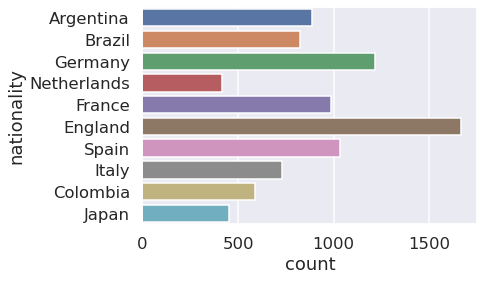

In [91]:
# YOUR CODE HERE
top_10 = df['nationality'].value_counts()[:10].index.tolist()
top_10_df = df[df['nationality'].isin(top_10)]
sns.countplot(y=top_10_df['nationality'])

From the plot you generated, you should see that England is the most common nationality, but that France and Brazil (our countries of interest) are in the top 10.

### 2b) Scatterplot Matrix

Using `scatter_matrix`, from `pandas`' `plotting` module, plot `df` for the 5 columns `age`, `height`, `weight`, `'potential`, and `overall`. Assign it to a variable called `fig`. 

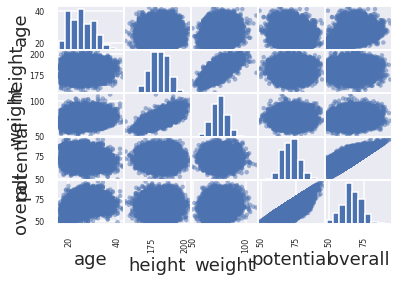

In [93]:
# YOUR CODE HERE
fig = pd.plotting.scatter_matrix(df[['age', 'height', 'weight', 'potential', 'overall']])

In [94]:
assert np.all(fig)

From this plot, you should get a sense of the range/possible values for each variable and see that potential and overall are certainly related to one another, as are height and weight. However, as we would expect, age is not closely related to any of the other variables.

## Part 3: Analysis

While we haven't fully explored the data, for the purposes of this workbook, let's get to answering some questions! For this, we're only going to focus in on players from two countries: France and Brazil and we'll answer the following questions:

1. Do the heights of players differ between Brazil and France?
2. Do the weights of players differ between Brazil and France?
4. What is the effect of nationality on overall rating?

### 3a) Subset Data

Obtain a subset of the original dataframe `df`, including only players whose `nationality` is either 'Brazil' or 'France'. Store this in `df_sub`

In [95]:
# YOUR CODE HERE
rows_to_keep = df['nationality'].isin(['Brazil', 'France'])
df_sub = df[rows_to_keep]

In [ ]:
assert df_sub.shape == (1808, 15)

### 3b) Weight

Extract the weight data for all French players, storing it in `w_france`.

Extract the weight data for all Brazilian players, storing it in `w_brazil`.

In [96]:
w_france = df[df['nationality'] == 'France']['weight']
w_brazil = df[df['nationality'] == 'Brazil']['weight']

### 3c) Difference in weight?

Carry out a t-test (using the `ttest_ind()` function) to compare the two distributions. Store the test statstic in the variable `t_val` and the p-value in the variable `p_val`.

In [98]:
# YOUR CODE HERE
t_val, p_val = ttest_ind(a=w_france, b=w_brazil)

In [99]:
# look at results
t_val, p_val

(-1.7586424201253648, 0.07880760827880617)

In [100]:
assert np.isclose(t_val, -1.76, atol = 0.01)
assert np.isclose(p_val, 0.079, atol = 0.01)

In [101]:
# Check if statistical test passes significance
# using an alpha value of 0.01. This code provided.
if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is NOT a significant difference!


### 3d) Height

Carry out the same process as above for height to determine if the heights of players differ between France and Brazil. Again, store the output in `t_val` and `p_val`

In [102]:
# YOUR CODE HERE
h_france = df[df['nationality'] == 'France']['height']
h_brazil = df[df['nationality'] == 'Brazil']['height']
t_val, p_val = ttest_ind(a=h_france, b=h_brazil)
t_val, p_val

(2.1929115752754877, 0.02844089362836709)

In [103]:
assert np.isclose(t_val, 2.19, atol = 0.01)
assert np.isclose(p_val, 0.028, atol = 0.01)

### 3e) Who's taller?

In 3d, you should have determined that there is a height difference between French and Brazilian soccer players...but who's taller? Determine the difference in means here, storing the mean height for each country in `mean_france` and `mean_brazil`, respectively.

In [104]:
# YOUR CODE HERE
mean_france = h_france.mean()
mean_brazil = h_brazil.mean()

In [105]:
assert np.isclose(mean_france, 181.34, atol = 0.01)
assert np.isclose(mean_brazil, 180.67, atol = 0.01)

### 3f) Overall

While height and weight may affect your soccer prowess, how you perform is what ultimately matters. Let's determine the relationship (French vs. Brazil) between nationality and `overall` score in `df_sub` using `OLS` from `statsmodels`.

The null hypothesis here would be that there is no relationship between nationality and `overall` score. 

Store the results from your analysis in the variable `res_1`.

In [108]:
# YOUR CODE HERE
dependent, predictors = patsy.dmatrices('overall ~ nationality', df_sub)
model = sm.OLS(dependent, predictors)
res_1 = model.fit()

In [109]:
assert isinstance(res_1, sm.regression.linear_model.RegressionResultsWrapper)

In [110]:
# look at results
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     151.9
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           1.43e-33
Time:                        19:30:38   Log-Likelihood:                -5930.3
No. Observations:                1808   AIC:                         1.186e+04
Df Residuals:                    1806   BIC:                         1.188e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                71.16

In this model, you should see that, on average, French players tend to have significantly lower overall scores, relative to Brazilians. Our first piece of evidence suggesting that Brazil may be the country that produces the best players! However, we only looked at two countries here...and only looked at one feature. We'd have to do a lot more digging/analysis before determining that conclusively!